In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import numpy as np
import matplotlib.pyplot as plt
from tomophantom import TomoP2D
from tomophantom import TomoP3D
from tomophantom.generator import foam2D, foam3D
import os
import gc
import tomopy
import torch.nn.functional as F
import random
import torch
from inr import models
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from math import exp
import math 
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from focal_frequency_loss import FocalFrequencyLoss as FFL
from train_tomo_alignment import *
from utils import *
device_id = 1 # 或者你想使用的其他设备 ID
torch.cuda.set_device(device_id)
import scipy.io as scio
import h5py
from tomocupy_stream import GPURecRAM
from tomocupy_stream import find_center
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time

/home/cxhpc/anaconda3/envs/tomocupy/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
astropy module not found


Generating 3D random phantom


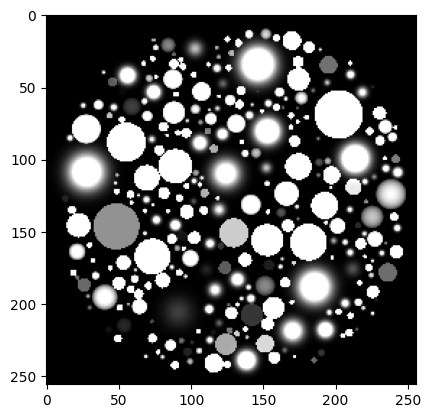

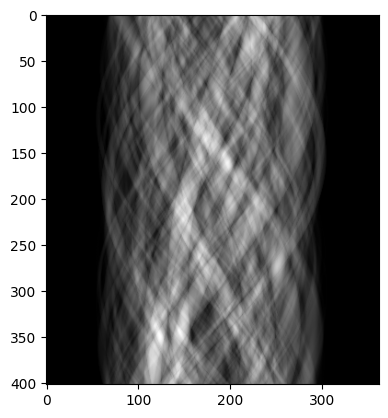

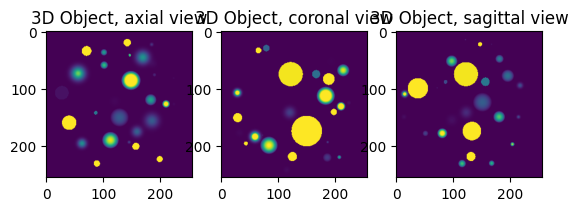

Building 3D analytical projection data with TomoPhantom
(256, 402, 362)


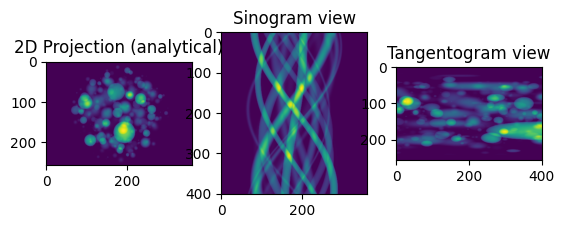

In [2]:
############# generate data##########################
N_size = 256  # define the grid size
tot_objects =300 # the total number of objects to generate
# define ranges for parameters
x0min = -0.9
x0max = 0.9
y0min = -0.9
y0max = 0.9
z0min = -0.9
z0max = 0.9
c0min = 0.01
c0max = 1.0
ab_min = 0.01
ab_max = 0.25
# 2D example
(Objfoam2D, myObjects) = foam2D(
    x0min,
    x0max,
    y0min,
    y0max,
    c0min,
    c0max,
    ab_min,
    ab_max,
    N_size,
    tot_objects,
    object_type="mix",
)
plt.figure()
plt.imshow(Objfoam2D, vmin=0, vmax=0.3, cmap="gray")

# Generate a sinogram
angles_num = int(0.5 * np.pi * N_size)
# angles number
angles = np.linspace(0, 180, angles_num, dtype="float32")
angles_rad = angles * (np.pi / 180)
P = int(np.sqrt(2) * N_size)  # detectors

sino_Objfoam2D = TomoP2D.ObjectSino(N_size, P, angles, myObjects)
plt.figure()
plt.imshow(sino_Objfoam2D, cmap="gray")

# %%
# 3D example
print("Generating 3D random phantom")
(Objfoam3D, myObjects) = foam3D(
    x0min,
    x0max,
    y0min,
    y0max,
    z0min,
    z0max,
    c0min,
    c0max,
    ab_min,
    ab_max,
    N_size,
    tot_objects,
    object_type="mix",
)
plt.figure()
sliceSel = int(0.5 * N_size)
plt.subplot(131)
plt.imshow(Objfoam3D[sliceSel, :, :], vmin=0, vmax=0.5)
plt.title("3D Object, axial view")

plt.subplot(132)
plt.imshow(Objfoam3D[:, sliceSel, :], vmin=0, vmax=0.5)
plt.title("3D Object, coronal view")

plt.subplot(133)
plt.imshow(Objfoam3D[:, :, sliceSel], vmin=0, vmax=0.5)
plt.title("3D Object, sagittal view")
plt.show()

Horiz_det = int(np.sqrt(2) * N_size)  # detector column count (horizontal)
Vert_det = N_size  # detector row count (vertical) (no reason for it to be > N)
angles_num = int(0.5 * np.pi * N_size)
# angles number
angles = np.linspace(0.0, 179.9, angles_num, dtype="float32")  # in degrees

print("Building 3D analytical projection data with TomoPhantom")
ProjData3D = TomoP3D.ObjectSino(N_size, Horiz_det, Vert_det, angles, myObjects)
print(ProjData3D.shape)
sliceSel = 150
plt.figure()
plt.subplot(131)
plt.imshow(ProjData3D[:, sliceSel, :])
plt.title("2D Projection (analytical)")
plt.subplot(132)
plt.imshow(ProjData3D[sliceSel, :, :])
plt.title("Sinogram view")
plt.subplot(133)
plt.imshow(ProjData3D[:, :, sliceSel])
plt.title("Tangentogram view")
plt.show()

In [3]:
def plot_projections(sid=1):
    plt.imshow(ProjData3D [sid,:,:],cmap='gray')
interact(plot_projections, sid = widgets.IntSlider(value=ProjData3D.shape[0]//2,
                                               min=0,
                                               max=ProjData3D.shape[0]-1,
                                               step=1))

interactive(children=(IntSlider(value=128, description='sid', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.plot_projections(sid=1)>

In [4]:
proj=ProjData3D.swapaxes(0,1)                 ### or proj=np.load('./Data/tomo_data/proj_simulation.npy')
proj=proj/np.max(proj)
c,h,w= proj.shape
print(np.min(proj), np.max(proj))

0.0 1.0


In [5]:
#################add jitter########################
seed = 42
random.seed(seed)
torch.manual_seed(seed)
print(f'Randomness is fixed with seed: {seed}')
#  sim :(c, h, w)
sim = torch.tensor(proj, dtype=torch.float32)  # shape: (c, 256, 362)
# random shift
def generate_random_shifts(num_samples, shift_range=(-0.2, 0.2)):
    shifts = torch.zeros((num_samples, 2))
    for i in range(num_samples):
        shifts[i, 0] = random.uniform(*shift_range)
        shifts[i, 1] = random.uniform(*shift_range)
    return shifts
truth_shifts = generate_random_shifts(c)  # shape: (c, 2)
y = batch_affine_transform(sim, truth_shifts)  # shape: (c, 256, 362)
print(y.shape)

Randomness is fixed with seed: 42
torch.Size([402, 256, 362])


/home/cxhpc/anaconda3/envs/tomocupy/lib/python3.12/site-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/cxhpc/anaconda3/envs/tomocupy/lib/python3.12/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [6]:
y=y.numpy()
print(np.min(y), np.max(y))
def plot_projections(sid=1):
    plt.imshow(y[sid,:,:],cmap='gray')
interact(plot_projections, sid = widgets.IntSlider(value=y.shape[0]//2,
                                               min=0,
                                               max=y.shape[0]-1,
                                               step=1))

0.0 0.9975962


interactive(children=(IntSlider(value=201, description='sid', max=401), Output()), _dom_classes=('widget-inter…

<function __main__.plot_projections(sid=1)>

In [7]:
########## add noisy############
mean = 0  
stddev = 0.1 # std
y_noisy=y+ np.random.normal(mean, stddev, proj.shape)

In [8]:
######### Coordinate, Model, loss function, dark, flat, theta################
temporal_coord=get_coordinate(c)
k=2
temporal_params = {'nonlin': 'siren', 'in_features': 1, 'out_features': k,
                   'hidden_features': 256, 'hidden_layers': 3, 'outermost_linear': True}
temporal_model = models.get_INR(**temporal_params)
print(f'temporal_coord, shape: {temporal_coord.shape}, range: {temporal_coord.min(), temporal_coord.max()}')
ffl = FFL(loss_weight=3, alpha=1)
dark = np.zeros([1,h,w],dtype='float32')
flat = np.ones([1,h,w],dtype='float32')
data = np.zeros([c,h,w],dtype='float32')
data = data.swapaxes(0,1)
theta = np.linspace(0,180,402).astype('float32')

temporal_coord, shape: torch.Size([402, 1]), range: (tensor(-1.), tensor(1.))


In [10]:
tomo_alignment_results=projection_reprojection_alignment(y_noisy, sim.numpy(), dark, flat, theta, data, temporal_coord, temporal_model,ffl,temperature=1,mode='bicubic')

auto rotation axis 180.5
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 


/home/cxhpc/data/wt/Tomography_alignment/train_tomo.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 混合精度训练
/home/cxhpc/anaconda3/envs/tomocupy/lib/python3.12/site-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/cxhpc/anaconda3/envs/tomocupy/lib/python3.12/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[0/10], error: 3.2402, all_psnr: 22.08
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
[1/10], error: 0.3254, all_psnr: 23.60
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
[2/10], error: 0.0576, all_psnr: 24.03
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
[3/10], error: 0.0451, all_psnr: 24.21
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
[4/10], error: 0.0371, all_psnr: 24.32
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
[5/10], error: 0.0329, all_psnr: 24.40
chunk 032/032 |  |████████████████████████████████████████| 100.0% 
chunk 032/032 |  |

In [11]:
pred= tomo_alignment_results['pred']

In [12]:
pred[pred<=0]=0
def plot_projections(sid=1):
    plt.imshow(pred[:,sid,:],cmap='gray')
interact(plot_projections, sid = widgets.IntSlider(value=pred.shape[1]//2,
                                               min=0,
                                               max=pred.shape[1]-1,
                                               step=1))

interactive(children=(IntSlider(value=128, description='sid', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.plot_projections(sid=1)>

In [13]:
def plot_projections(sid=1):
    plt.imshow(y_noisy[:,sid,:],cmap='gray')
interact(plot_projections, sid = widgets.IntSlider(value=y_noisy.shape[1]//2,
                                               min=0,
                                               max=y_noisy.shape[1]-1,
                                               step=1))

interactive(children=(IntSlider(value=128, description='sid', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.plot_projections(sid=1)>